# Sucrose-Inversion Kinetics (CEU) Lab for CBE 154
Presented by Group MW1: Rahil Shaik, Sneha Kancharla, Alex Quemuel, Ethan Mibu

### We will start our data analysis with some package imports, reading in our data, data preprocessing (converting units, changing column names, etc), and some basic EDA

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, root_scalar,fsolve
from scipy.stats import linregress
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

### Glucose Standard Results

In [293]:
warnings.filterwarnings("ignore")

In [294]:
df_stand = pd.read_csv("glucose-standard-res.csv")
df_stand

,Concentration of Reagent (g/L),Absorbance
0,0.02,0.52182
1,0.04,0.85720
2,0.06,1.03990
3,0.08,1.24860


##### our cuvette has a path length of 1 cm, so let's convert our concentration to units of cm^3

In [295]:
df_stand["Concentration (g/cm^3)"] = df_stand["Concentration of Reagent (g/L)"] * (1/1000)
df_stand

,Concentration of Reagent (g/L),Absorbance,Concentration (g/cm^3)
0,0.02,0.52182,0.00002
1,0.04,0.85720,0.00004
2,0.06,1.03990,0.00006
3,0.08,1.24860,0.00008


##### Now adjusting the absoprtion with the DI water baseline
##### $$ A_{\text{glucose,adj}} = A_{\text{glucose}} - A_{\text{DIW}}$$

In [296]:
A_DI1 = 0.1256 # DI Water Baseline Absorbance Day 1
A_DI2 = 0.13629 # DI Water Baseline Absorbance Day 2

df_stand["Absorbance adjusted"] = df_stand["Absorbance"].apply(lambda x: x - A_DI1)
df_stand

,Concentration of Reagent (g/L),Absorbance,Concentration (g/cm^3),Absorbance adjusted
0,0.02,0.52182,0.00002,0.39622
1,0.04,0.85720,0.00004,0.73160
2,0.06,1.03990,0.00006,0.91430
3,0.08,1.24860,0.00008,1.12300


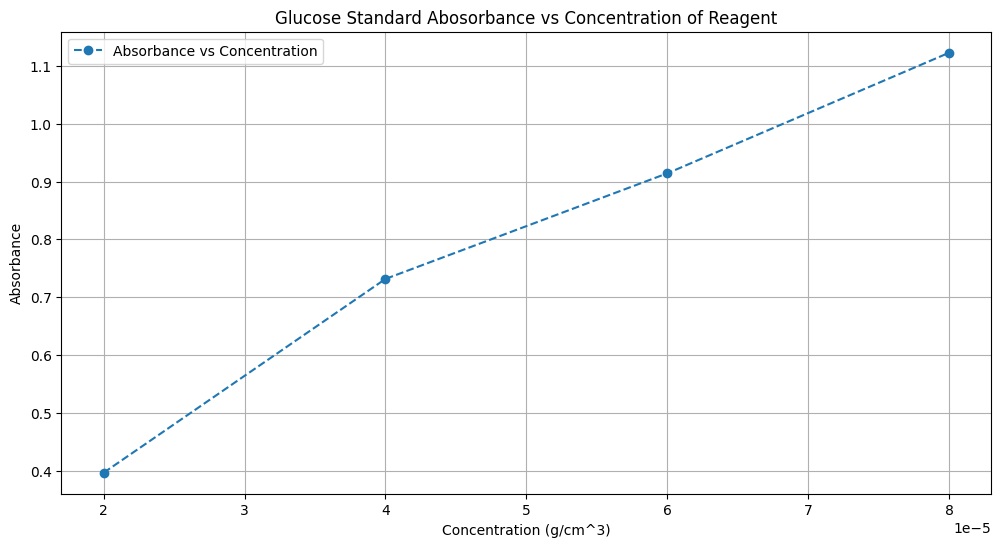

In [297]:
plt.figure(figsize=(12,6))
plt.plot(df_stand["Concentration (g/cm^3)"], df_stand["Absorbance adjusted"], label = "Absorbance vs Concentration",  marker= "o", linestyle="--")
plt.xlabel("Concentration (g/cm^3)")
plt.ylabel("Absorbance")
plt.title("Glucose Standard Abosorbance vs Concentration of Reagent")
plt.grid()
plt.legend()

plt.show()

### CEU Glucose Product Results

##### Let's update our celsius temperature to Kelvin for our data analysis

In [298]:
df_res = pd.read_csv("CEU-glucose-results.csv")
df_res["Temperature"] = df_res["Temperature"] + 273.15

In [299]:
def adjust_absorbance(day, absorbance, A_DI1, A_DI2):
    if day == 1:
        return absorbance - A_DI1
    elif day == 2:
        return absorbance - A_DI2
    else:
        raise ValueError("Invalid day value")
    
df_res["Absorbance adjusted"] = df_res.apply(lambda x: adjust_absorbance(x["Day"], x["Absorbance"], A_DI1, A_DI2), axis=1)

df_res

,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted
0,1,1,323.15,1.46190,1,1.33630
1,1,1,323.15,1.52420,2,1.39860
2,1,1,323.15,1.57910,3,1.45350
3,1,1,333.15,0.90298,1,0.77738
4,1,1,333.15,1.89460,2,1.76900
5,1,1,333.15,1.73960,3,1.61400
6,1,1,343.15,1.71290,1,1.58730
7,1,1,343.15,1.84670,2,1.72110
8,1,1,343.15,1.83360,3,1.70800
9,2,2,323.15,1.61280,1,1.47651


## Data Analysis Question 3: 
### Determine the steady state conversion for both reactors

##### Instead of taking the average like is shown in the commented code, we took the most recent sample as absorption values change with time

In [300]:
# df_grouped = df_res.groupby(["Day", "Type", "Temperature"])["Absorbance adjusted"].mean().reset_index()
# df_grouped.rename(columns={"Absorbance adjusted": "Absorbance adjusted meaned"}, inplace=True)
# df_grouped

In [301]:
df_recent = df_res.query("Sample == 3").reset_index()
df_recent

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted
0,2,1,1,323.15,1.5791,3,1.45350
1,5,1,1,333.15,1.7396,3,1.61400
2,8,1,1,343.15,1.8336,3,1.70800
3,11,2,2,323.15,1.6542,3,1.51791
4,14,2,2,333.15,1.6690,3,1.53271
5,17,2,2,343.15,1.7100,3,1.57371


##### Now let's use Beer-Lambert law to determine glucose concentration from the absorbance, the first step is to find the absorptivity of the glucose reagent
##### $$A = \epsilon \cdot c \cdot l$$



In [302]:
df_stand["Molar absorptivity"] = df_stand["Absorbance adjusted"] / df_stand["Concentration (g/cm^3)"] 
avg_molar_absorptivity = df_stand["Molar absorptivity"].mean()
df_stand

,Concentration of Reagent (g/L),Absorbance,Concentration (g/cm^3),Absorbance adjusted,Molar absorptivity
0,0.02,0.52182,0.00002,0.39622,19811.000000
1,0.04,0.85720,0.00004,0.73160,18290.000000
2,0.06,1.03990,0.00006,0.91430,15238.333333
3,0.08,1.24860,0.00008,1.12300,14037.500000


##### Beer-lambert law with 1 cm path length given by cuvette

In [303]:
path_length = 1 # cm
df_recent["Glucose concentration (g/cm^3)"] = df_recent["Absorbance adjusted"] / (avg_molar_absorptivity * path_length)

In [304]:
df_recent.query("Type == 2")["Glucose concentration (g/cm^3)"]

3    0.000090
4    0.000091
5    0.000093
Name: Glucose concentration (g/cm^3), dtype: float64

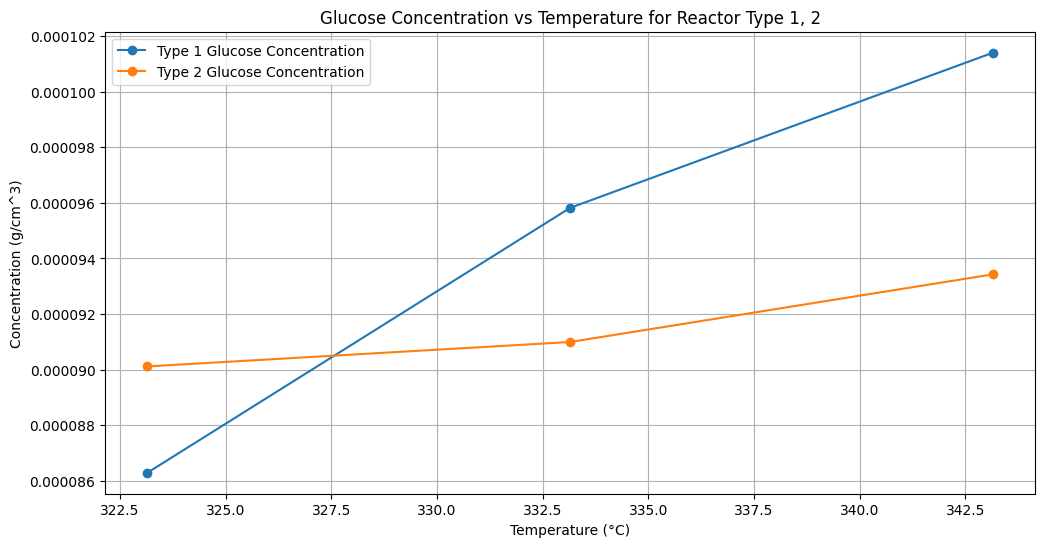

In [305]:
plt.figure(figsize=(12,6))
plt.plot(df_recent.query("Type == 1")["Temperature"], df_recent.query("Type == 1")["Glucose concentration (g/cm^3)"], label = "Type 1 Glucose Concentration", marker= "o")
plt.plot(df_recent.query("Type == 2")["Temperature"], df_recent.query("Type == 2")["Glucose concentration (g/cm^3)"], label = "Type 2 Glucose Concentration", marker= "o")
plt.xlabel("Temperature (°C)")
plt.ylabel("Concentration (g/cm^3)")
plt.title("Glucose Concentration vs Temperature for Reactor Type 1, 2")
plt.legend()
plt.grid()

plt.show()

## Data Analysis Question 4: 
### Use your data to determine the rate constant and diffusion coefficient by simultaneously solving data from the two reactors at a given temperature. To do this correctly you will need either MATLAB or Excel to solve a nonlinear algebraic equation for the kinetic constant at each temperature performed.

##### Now using our surcose feed concentration, we can determine steady state conversion:
##### $$C_{\text{glucose}} = C_{\text{sucrose},0} \cdot X$$
##### $$X = \frac{C_{\text{glucose}}}{C_{\text{sucrose},i}}$$


In [306]:
C_sucrose_i = 7.6 * (1/1000) # g/cm^3
df_recent["Conversion"] = df_recent["Glucose concentration (g/cm^3)"] / C_sucrose_i

In [307]:
df_recent

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion
0,2,1,1,323.15,1.5791,3,1.45350,0.000086,0.011354
1,5,1,1,333.15,1.7396,3,1.61400,0.000096,0.012608
2,8,1,1,343.15,1.8336,3,1.70800,0.000101,0.013342
3,11,2,2,323.15,1.6542,3,1.51791,0.000090,0.011857
4,14,2,2,333.15,1.6690,3,1.53271,0.000091,0.011973
5,17,2,2,343.15,1.7100,3,1.57371,0.000093,0.012293


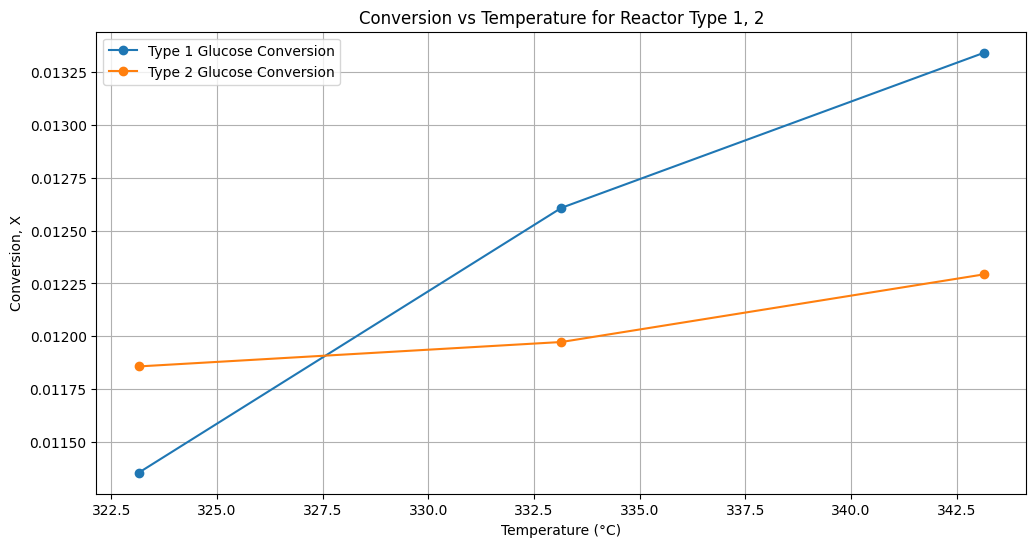

In [308]:
plt.figure(figsize=(12,6))
plt.plot(df_recent.query("Type == 1")["Temperature"], df_recent.query("Type == 1")["Conversion"], label = "Type 1 Glucose Conversion", marker= "o")
plt.plot(df_recent.query("Type == 2")["Temperature"], df_recent.query("Type == 2")["Conversion"], label = "Type 2 Glucose Conversion", marker= "o")
plt.xlabel("Temperature (°C)")
plt.ylabel("Conversion, X")
plt.title("Conversion vs Temperature for Reactor Type 1, 2")
plt.legend()
plt.grid()

plt.show()

### Solving for rate constant, k and diffusion coefficient, D

##### Starting with k, our goal here is to use the relationship between conversion and k to solve:
##### $$\ln(1 - X) = -\frac{k \cdot (1 - \epsilon) \cdot L}{\text{velocity}}$$
##### $$k = -\frac{\ln(1 - X) \cdot \text{velocity}}{(1 - \epsilon) \cdot L}$$


In [309]:
r1 =  (0.52 * .1) / 2 # Particle radius for smaller diameter resin (cm)
r2 = (1.1 * .1) / 2 # Particle radius for larger diameter resin (cm)
epsilon1 = 0.40  # Void fraction for smaller 
epsilon2 = 0.38  # Void fraction for larger 
L = 25.0 # cm
area = np.pi * (1.25 ** 2)
volume = L * area
flow = 10 # ml/min = cm^3/min
velocity = 10 / area # ml/min = cm^3/min /A = cm / min
tau = volume / flow # min

In [310]:
df_recent.loc[df_recent["Type"] == 1, "Rate constant (k)"] = (
    -np.log(1 - df_recent.loc[df_recent["Type"] == 1, "Conversion"]) * velocity
    / ((1 - epsilon1) * L)
)

df_recent.loc[df_recent["Type"] == 2, "Rate constant (k)"] = (
    -np.log(1 - df_recent.loc[df_recent["Type"] == 2, "Conversion"]) * velocity
    / ((1 - epsilon2) * L)
)

df_recent


,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion,Rate constant (k)
0,2,1,1,323.15,1.5791,3,1.45350,0.000086,0.011354,0.001551
1,5,1,1,333.15,1.7396,3,1.61400,0.000096,0.012608,0.001723
2,8,1,1,343.15,1.8336,3,1.70800,0.000101,0.013342,0.001824
3,11,2,2,323.15,1.6542,3,1.51791,0.000090,0.011857,0.001568
4,14,2,2,333.15,1.6690,3,1.53271,0.000091,0.011973,0.001583
5,17,2,2,343.15,1.7100,3,1.57371,0.000093,0.012293,0.001626


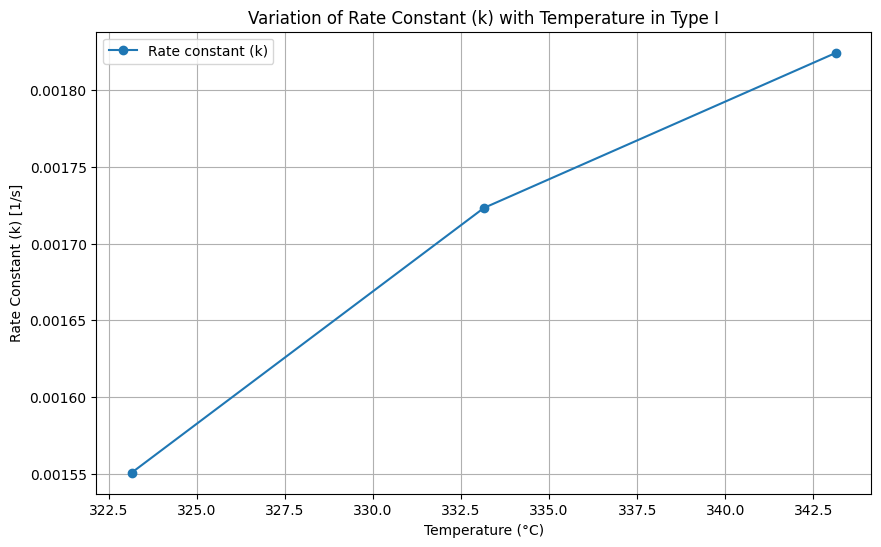

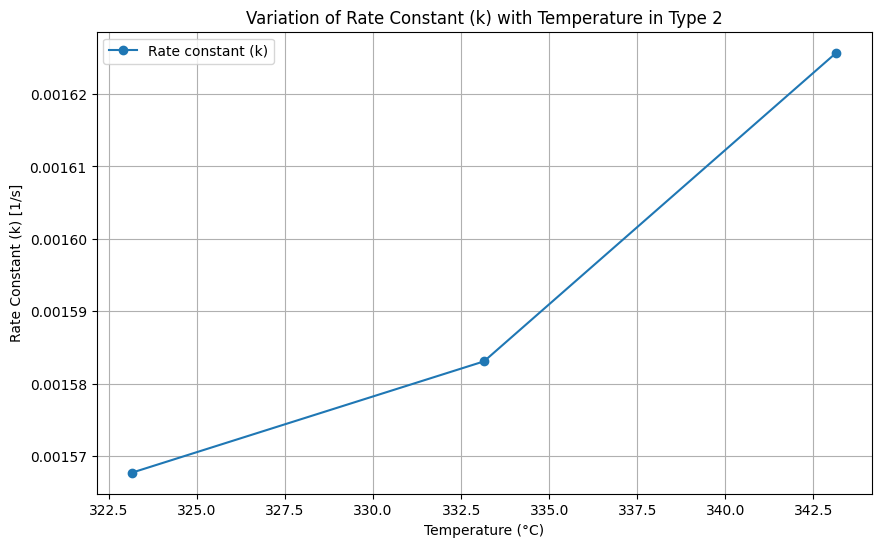

In [311]:
plt.figure(figsize=(10, 6))
plt.plot(df_recent.query("Type == 1")["Temperature"], df_recent.query("Type == 1")["Rate constant (k)"], marker='o', label="Rate constant (k)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Rate Constant (k) [1/s]")
plt.title("Variation of Rate Constant (k) with Temperature in Type I")
plt.grid()
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(df_recent.query("Type == 2")["Temperature"], df_recent.query("Type == 2")["Rate constant (k)"], marker='o', label="Rate constant (k)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Rate Constant (k) [1/s]")
plt.title("Variation of Rate Constant (k) with Temperature in Type 2")
plt.grid()
plt.legend()

plt.show()

##### Now, let's do Diffusivity for each reactor. We can start by partitioning our dataset into two dataframes for type 1 and type 2

In [312]:
df_1 = df_recent.query("Type == 1")
df_2 = df_recent.query("Type == 2")
df_1.head()

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion,Rate constant (k)
0,2,1,1,323.15,1.5791,3,1.4535,0.000086,0.011354,0.001551
1,5,1,1,333.15,1.7396,3,1.6140,0.000096,0.012608,0.001723
2,8,1,1,343.15,1.8336,3,1.7080,0.000101,0.013342,0.001824



#### $$\ln(1 - X_1) = \frac{(1 - \epsilon_1) R_{1}^2 (R_{1}p \coth(R_{1}p) - 1)}{(1 - \epsilon_2) R_{2}^2 (R_{2}p \coth(R_{2}p) - 1)} \tag{4}$$

##### $$p = \sqrt{\frac{k}{D_e}} \tag{5}$$


##### Since we have an implicit funciton here, we have to build a solver to solve for De iteratively. The commented code is an optimization algorithm showing that if you change the initial guess, the solver always converges to the same value

In [313]:
def solve_for_De(row, typ, p_guess):
    R   = r1
    k   = row["Rate constant (k)"]
    eps = epsilon1 if typ == 1 else epsilon2
    X   = row["Conversion"]
    
    def residual(p):
        left_side = np.log(1 - X)
        
        if p <= 0:
            return 1e9
        
        coth_term = np.cosh(R*p) / np.sinh(R*p)
        right_side = -3.0 * tau * k * (1.0 - eps) * (R*p*coth_term - 1.0) / (R**2 * p**2)
        
        return left_side - right_side

    p_guess = 1
    p_sol, info, ier, mesg = fsolve(residual, p_guess, full_output=True)
    
    if ier != 1:
        raise RuntimeError(f"fsolve failed to converge: {mesg}")
    
    p_sol = p_sol[0]
    De = k / (p_sol**2)
    return De


def run_solver(df, typ, p_guess):
    df[f"De_{typ}"] = df.apply(lambda row: solve_for_De(row, typ, p_guess=p_guess), axis=1)
    return df

# rang = np.linspace(1 ,1e3, 100)  # --> PROOF THAT SOLVER ATTENUATES TO CORRECT VALUE ~ 15 for type 1 De at 50 C
# for i in rang:
#     print(run_solver(df_1, 1, i)["De_1"].iloc[0])
#     print(run_solver(df_2, 2, i)["De_2"].iloc[0])

df_1 = run_solver(df_1, 1, 1)
df_2 = run_solver(df_2, 2, 1)


##### Here are the updated dataframes for type 1 and 2 with diffusivity values at the rightmost column. Reference from data analysis question 6.

In [314]:
df_1.head()

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion,Rate constant (k),De_1
0,2,1,1,323.15,1.5791,3,1.4535,0.000086,0.011354,0.001551,0.001551
1,5,1,1,333.15,1.7396,3,1.6140,0.000096,0.012608,0.001723,0.001723
2,8,1,1,343.15,1.8336,3,1.7080,0.000101,0.013342,0.001824,0.001824


In [315]:
df_2.head()

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion,Rate constant (k),De_2
3,11,2,2,323.15,1.6542,3,1.51791,0.000090,0.011857,0.001568,0.001568
4,14,2,2,333.15,1.6690,3,1.53271,0.000091,0.011973,0.001583,0.001583
5,17,2,2,343.15,1.7100,3,1.57371,0.000093,0.012293,0.001626,0.001626


## Data Analysis Question 5:
### Calculate the Theile modulus and effectiveness factors for the two reactors

##### Now we have the following expression for thiele modulus as a functin of diffusivity, De and rate constant, k
##### $$\phi_1 = R \sqrt{\frac{k'_1 \rho_c S_a}{D_e}} \;=\; R \sqrt{\frac{k_1}{D_e}}$$


In [316]:
df_1["thiele"] = r1 * np.sqrt(df_1["Rate constant (k)"] / df_1["De_1"])
df_2["thiele"] = r2 * np.sqrt(df_2["Rate constant (k)"] / df_2["De_2"])

In [317]:
df_2

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion,Rate constant (k),De_2,thiele
3,11,2,2,323.15,1.6542,3,1.51791,0.000090,0.011857,0.001568,0.001568,0.055
4,14,2,2,333.15,1.6690,3,1.53271,0.000091,0.011973,0.001583,0.001583,0.055
5,17,2,2,343.15,1.7100,3,1.57371,0.000093,0.012293,0.001626,0.001626,0.055


In [318]:
df_1

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion,Rate constant (k),De_1,thiele
0,2,1,1,323.15,1.5791,3,1.4535,0.000086,0.011354,0.001551,0.001551,0.026
1,5,1,1,333.15,1.7396,3,1.6140,0.000096,0.012608,0.001723,0.001723,0.026
2,8,1,1,343.15,1.8336,3,1.7080,0.000101,0.013342,0.001824,0.001824,0.026


##### Now getting the effectiveness factor
##### $$\eta = - \frac{\ln\bigl(1 - X_A\bigr)}{k \, \tau \,\bigl(1 - \epsilon\bigr)} = \frac{3}{\phi}\Bigl(\coth(\phi)\;-\;\frac{1}{\phi}\Bigr)$$

In [319]:
# def coth(x):
#     return 1/np.tanh(x)

# df_1["effectiveness"] = (3/df_1["thiele"]) * (coth(df_1["thiele"]) - (1/df_1["thiele"]))
# df_2["effectiveness"] = (3/df_2["thiele"]) * (coth(df_2["thiele"]) - (1/df_2["thiele"]))

df_1["effectiveness"] = 10 * -np.log(1-df_1["Conversion"] * .1) / (df_1["Rate constant (k)"] * tau * (1-epsilon1))
df_2["effectiveness"] = 10 * -np.log(1-df_2["Conversion"] * .1) / (df_2["Rate constant (k)"] * tau * (1-epsilon2))

In [320]:
df_2

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion,Rate constant (k),De_2,thiele,effectiveness
3,11,2,2,323.15,1.6542,3,1.51791,0.000090,0.011857,0.001568,0.001568,0.055,0.994649
4,14,2,2,333.15,1.6690,3,1.53271,0.000091,0.011973,0.001583,0.001583,0.055,0.994597
5,17,2,2,343.15,1.7100,3,1.57371,0.000093,0.012293,0.001626,0.001626,0.055,0.994452


In [321]:
df_1

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion,Rate constant (k),De_1,thiele,effectiveness
0,2,1,1,323.15,1.5791,3,1.4535,0.000086,0.011354,0.001551,0.001551,0.026,0.994877
1,5,1,1,333.15,1.7396,3,1.6140,0.000096,0.012608,0.001723,0.001723,0.026,0.994310
2,8,1,1,343.15,1.8336,3,1.7080,0.000101,0.013342,0.001824,0.001824,0.026,0.993977


## Data Analysis Question 10:
### From your data, calculate and compare the apparent and true activation energies for the reaction. 
##### Starting with apparent activation energies
##### $$\ln k = -\,\exp\!\Bigl(\frac{E_a}{R}\Bigr) \quad\Longrightarrow\quad E_a = R \,\ln\!\Bigl[-\,\ln\bigl(k\bigr)\Bigr] $$


In [322]:
R = 8.314 # J / mol * K
df_1["Apparent Activation Energy (J / mol*k)"] = R * np.log(-np.log(df_1["Rate constant (k)"]))
df_2["Apparent Activation Energy (J / mol*k)"] = R * np.log(-np.log(df_2["Rate constant (k)"]))
df_1

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion,Rate constant (k),De_1,thiele,effectiveness,Apparent Activation Energy (J / mol*k)
0,2,1,1,323.15,1.5791,3,1.4535,0.000086,0.011354,0.001551,0.001551,0.026,0.994877,15.522364
1,5,1,1,333.15,1.7396,3,1.6140,0.000096,0.012608,0.001723,0.001723,0.026,0.994310,15.385820
2,8,1,1,343.15,1.8336,3,1.7080,0.000101,0.013342,0.001824,0.001824,0.026,0.993977,15.311043


In [323]:
df_2

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion,Rate constant (k),De_2,thiele,effectiveness,Apparent Activation Energy (J / mol*k)
3,11,2,2,323.15,1.6542,3,1.51791,0.000090,0.011857,0.001568,0.001568,0.055,0.994649,15.508441
4,14,2,2,333.15,1.6690,3,1.53271,0.000091,0.011973,0.001583,0.001583,0.055,0.994597,15.495865
5,17,2,2,343.15,1.7100,3,1.57371,0.000093,0.012293,0.001626,0.001626,0.055,0.994452,15.461550


##### Now to get true activaton energy we can use the fact that
$$
k = A \exp\!\Bigl(-\frac{E_a}{R \, T}\Bigr)
\quad\Longrightarrow\quad
\ln k = \ln A \;-\;\frac{E_a}{R}\,\frac{1}{T}.
$$
##### giving our slope as activation energy over ideal gas constant and intercept as ln(A)

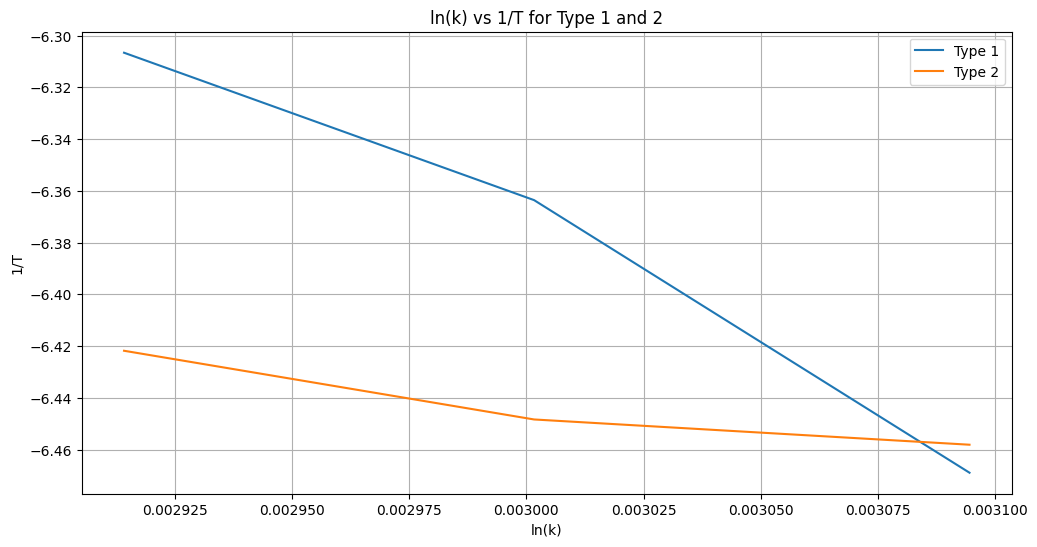

In [324]:
plt.figure(figsize=(12,6))
plt.plot(1 / (df_1["Temperature"]), np.log(df_1["Rate constant (k)"]), label="Type 1")
plt.plot(1 / (df_1["Temperature"]), np.log(df_2["Rate constant (k)"]), label="Type 2")
plt.title("ln(k) vs 1/T for Type 1 and 2")
plt.xlabel("ln(k)")
plt.ylabel("1/T")
plt.legend()
plt.grid()

##### These aren't exactly linear, so let's use some basic linear regression to extract a slope here

In [325]:
result_Ea_1 = linregress( 1 / (df_1["Temperature"]), np.log(df_1["Rate constant (k)"]))
print("Slope 1 = Type 1 -E_a {} R:".format("/"), result_Ea_1.slope)
print("Intercept 1 = Type 1 ln(A):", result_Ea_1.intercept)

result_Ea_2 = linregress( 1 / (df_1["Temperature"]), np.log(df_2["Rate constant (k)"]))
print("Slope 2 = Type 2 -E_a {} R:".format("/"), result_Ea_2.slope)
print("Intercept 2 = Type 2 ln(A):", result_Ea_2.intercept)

Slope 1 = Type 1 -E_a / R: -902.5712203152802
Intercept 1 = Type 1 ln(A): -3.6688837636474925
Slope 2 = Type 2 -E_a / R: -200.39138290080913
Intercept 2 = Type 2 ln(A): -5.840906936019439


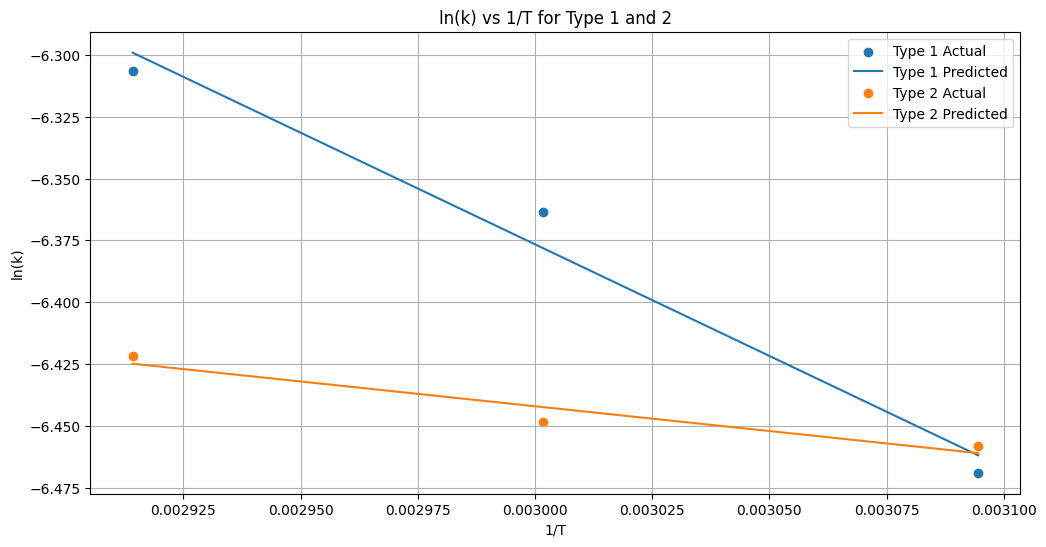

In [326]:
x_fit_1 = np.linspace(min(1/(df_1["Temperature"])), max(1/(df_1["Temperature"])), 10)
y_fit_1 = result_Ea_1.slope * x_fit_1 + result_Ea_1.intercept

x_fit_2 = np.linspace(min(1/(df_2["Temperature"])), max(1/(df_2["Temperature"])), 10)
y_fit_2 = result_Ea_2.slope * x_fit_2 + result_Ea_2.intercept

plt.figure(figsize=(12,6))
plt.scatter(1 / (df_1["Temperature"]), np.log(df_1["Rate constant (k)"]), label="Type 1 Actual")
plt.plot(x_fit_1, y_fit_1, label="Type 1 Predicted")
plt.scatter(1 / (df_2["Temperature"]), np.log(df_2["Rate constant (k)"]), label="Type 2 Actual")
plt.plot(x_fit_2, y_fit_2, label="Type 2 Predicted")
plt.title("ln(k) vs 1/T for Type 1 and 2")
plt.ylabel("ln(k)")
plt.xlabel("1/T")
plt.legend()
plt.grid()

##### So finally we arrive at the below activation energies for type 1 and 2

In [327]:
print("Type 1 True Activation Energy", -result_Ea_1.slope * R / 1000, "kJ/ mol*K")
print("Type 2 True Activation Energy", -result_Ea_2.slope * R / 1000,  "kJ/ mol*K")

Type 1 True Activation Energy 7.5039771257012395 kJ/ mol*K
Type 2 True Activation Energy 1.6660539574373272 kJ/ mol*K


##### We can see that the true activation energies are considerably higher than the apparent activation energies. See ORPT for further discussion of this finding.

## Data Analysis Question 11: 
### Based on your experimental results, calculate the effectiveness factor and conversion for a steady-state packed-bed reactor operating isothermally at 80 degrees C and packed full with 1.0 mm diameter spherical particles. Assume the void fraction is 0.40. The reactor setup is otherwise similar to that used in the laboratory. Plot the concentration down the length of the reactor to exit. (Note: the data shown in Figure 6 indicates a very sharp increase in effective diffusivity from 60 to 70 °C. Authors suggest creating a linear fit of effective diffusivity versus temperature data until 60 °C, and extrapolating to 80 °C rather than including the last data point).

##### We can use linear modeling to extrapolate our data to a new conditions: T = 353.15 K, eps = 40, d = .05 cm. This linear model will use linear regression with features of temperature, void fraction, and particle radius
##### The goal is to predict concentration to solve for conversion and effectiveness in a similar manner to the above steps

In [328]:
df_1["void fraction"] = [epsilon1] * len(df_1)
df_1["particle radius"] = [r1] * len(df_1)

df_2["void fraction"] = [epsilon2] * len(df_2)
df_2["particle radius"] = [r2] * len(df_2)

df_stacked = pd.concat([df_1, df_2])

In [329]:
X = df_stacked[["Temperature", "void fraction", "particle radius"]]
y = df_stacked["Glucose concentration (g/cm^3)"]

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

In [330]:
temperature_values = np.arange(303.15, 353.15, 1) # predicting from a range of temperatures from 30 C to 80 C 

X_pred = pd.DataFrame({
    "Temperature": temperature_values, 
    "void fraction": [0.40] * len(temperature_values), # void fraction of 0.40
    "particle radius": [0.05] * len(temperature_values) # predicting at particle radius of 0.5 cm
})

C_pred = model.predict(X_pred)
print("Predicted final concentration at T=80C:", C_pred[-1])


Predicted final concentration at T=80C: 0.00010157587527708783


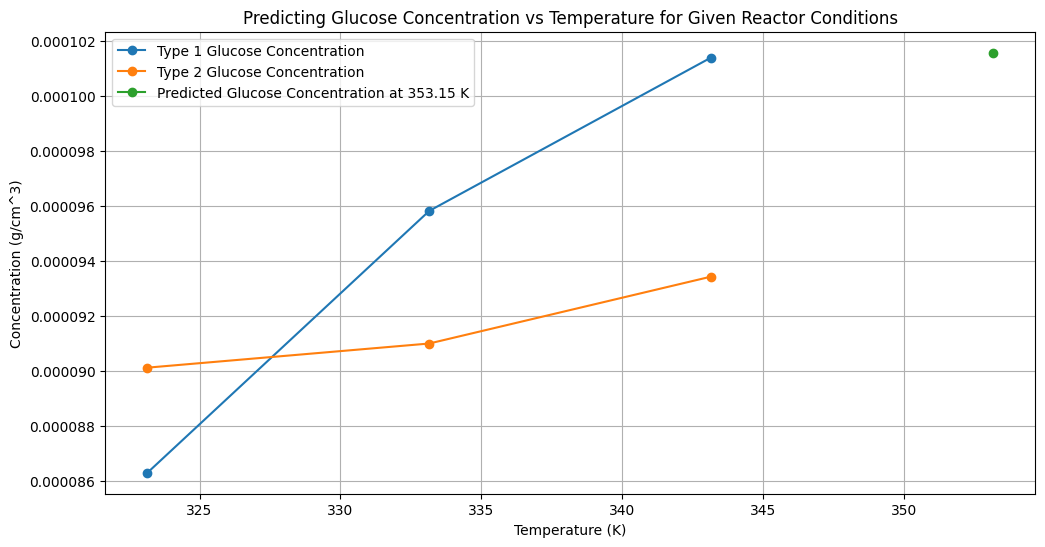

In [331]:
x_range_1 = np.linspace(min(df_1["Temperature"]), max(df_1["Temperature"]), len(df_1))
x_range_2 = np.linspace(min(df_2["Temperature"]), max(df_1["Temperature"]), len(df_2))

plt.figure(figsize=(12,6))
plt.plot(x_range_1, df_1["Glucose concentration (g/cm^3)"], label = "Type 1 Glucose Concentration", marker= "o")
plt.plot(x_range_2, df_2["Glucose concentration (g/cm^3)"], label = "Type 2 Glucose Concentration", marker= "o")
plt.plot(353.15, C_pred[-1], marker= "o", label = "Predicted Glucose Concentration at 353.15 K")
plt.xlabel("Temperature (K)")
plt.ylabel("Concentration (g/cm^3)")
plt.title("Predicting Glucose Concentration vs Temperature for Given Reactor Conditions")
plt.legend()
plt.grid()

plt.show()

##### This seems like a reasonable predicted concentration based on the type 1 and 2 reactors, if we fit a line to the two reactors, let's see how they compare to the predicted concentration

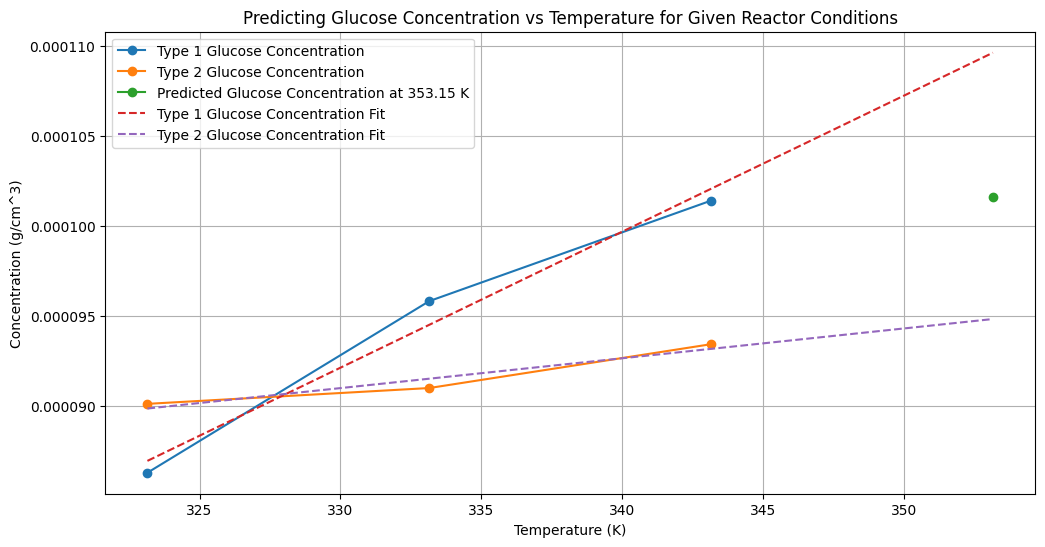

In [332]:
result_C_1 = linregress(df_1["Temperature"], df_1["Glucose concentration (g/cm^3)"])
result_C_2 = linregress(df_2["Temperature"], df_2["Glucose concentration (g/cm^3)"])

x_fit_1 = np.linspace(min(df_1["Temperature"]), 353.15, 10)
y_fit_1 = result_C_1.slope * x_fit_1 + result_C_1.intercept

x_fit_2 = np.linspace(min(df_2["Temperature"]), 353.15, 10)    
y_fit_2 = result_C_2.slope * x_fit_2 + result_C_2.intercept

plt.figure(figsize=(12,6))
plt.title("Predicting Glucose Concentration vs Temperature for Given Reactor Conditions")
plt.plot(df_1["Temperature"], df_1["Glucose concentration (g/cm^3)"], label = "Type 1 Glucose Concentration", marker= "o")
plt.plot(df_2["Temperature"], df_2["Glucose concentration (g/cm^3)"], label = "Type 2 Glucose Concentration", marker= "o")
plt.plot(353.15, C_pred[-1], marker= "o", label = "Predicted Glucose Concentration at 353.15 K")
plt.plot(x_fit_1, y_fit_1, label = "Type 1 Glucose Concentration Fit", linestyle = "dashed")
plt.plot(x_fit_2, y_fit_2, label = "Type 2 Glucose Concentration Fit", linestyle = "dashed")
plt.xlabel("Temperature (K)")
plt.ylabel("Concentration (g/cm^3)")
plt.grid()
plt.legend()
plt.show() 

##### Now we can use the same equation from before to compute conversion as a function of concentration
##### $$C_{\text{glucose}} = C_{\text{sucrose},0} \cdot X$$
##### $$X = \frac{C_{\text{glucose}}}{C_{\text{sucrose},i}}$$

In [333]:
conversion_pred = C_pred / C_sucrose_i
print("Predicted conversion at T=353.15 K:", conversion_pred[-1])

Predicted conversion at T=353.15 K: 0.01336524674698524


##### We now have our conversion, so our next step to solving effectiveness is finding k. Starting wit k, our goal here is to use the relationship between conversion and k to solve:
##### $$\ln(1 - X) = -\frac{k \cdot (1 - \epsilon) \cdot L}{\text{velocity}}$$
##### $$k = -\frac{\ln(1 - X) \cdot \text{velocity}}{(1 - \epsilon) \cdot L}$$

In [334]:
epsilon_pred = 0.40

k_pred = - (velocity * np.log(1 - conversion_pred)) / ((1 - epsilon_pred) * L)
print("Predicted rate constant at T=353.15 K:", k_pred[-1])

Predicted rate constant at T=353.15 K: 0.0018274030382123372


##### We can now use conversion and rate constant to solve for effectiveness
##### $$\eta = - \frac{\ln\bigl(1 - X_A\bigr)}{k \, \tau \,\bigl(1 - \epsilon\bigr)} = \frac{3}{\phi}\Bigl(\coth(\phi)\;-\;\frac{1}{\phi}\Bigr)$$

In [335]:
r_pred = 0.05

eta =  - 10 * np.log(1 - conversion_pred * .1) / (k_pred * tau * (1 - epsilon_pred))
print("Predicted effectiveness at T=353.15 K:", eta[-1])

Predicted effectiveness at T=353.15 K: 0.9939667690970653


##### To plot glucose concentration as a function of position down the reactor, we need to get the Arrhenius rate expression

In [336]:
Ea_pred = R * (np.log(k_pred) / (1 / temperature_values))
result_pred = linregress(np.log(k_pred), (1 / temperature_values))
A = result_pred.intercept

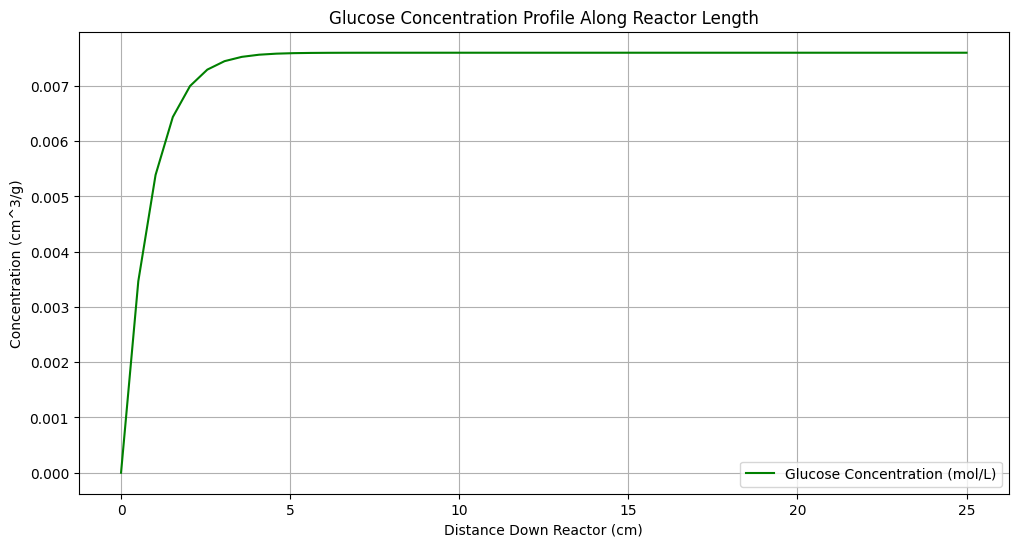

In [337]:
k = -A * np.exp(-Ea_pred / (R * 353.15))
z = np.linspace(0, L, 50)
Ca_corrected = C_sucrose_i * np.exp(-k * z / velocity)
Cg_corrected = C_sucrose_i - Ca_corrected

plt.figure(figsize=(12, 6))
plt.plot(z, Cg_corrected, label='Glucose Concentration (mol/L)', color='green')
plt.xlabel("Distance Down Reactor (cm)")
plt.ylabel("Concentration (cm^3/g)")
plt.title("Glucose Concentration Profile Along Reactor Length")
plt.legend()
plt.grid()
plt.show()

In [338]:
print("Type 1 Apparent Activation Energy", np.mean(df_2["Apparent Activation Energy (J / mol*k)"]) / 1000, "kJ/ mol*K")
print("Type 2 Apparent Activation Energy",np.mean(df_1["Apparent Activation Energy (J / mol*k)"]) / 1000,  "kJ/ mol*K")

Type 1 Apparent Activation Energy 0.015488618524086268 kJ/ mol*K
Type 2 Apparent Activation Energy 0.015406408914369656 kJ/ mol*K


In [339]:
df_stacked

,index,Day,Type,Temperature,Absorbance,Sample,Absorbance adjusted,Glucose concentration (g/cm^3),Conversion,Rate constant (k),De_1,thiele,effectiveness,Apparent Activation Energy (J / mol*k),void fraction,particle radius,De_2
0,2,1,1,323.15,1.5791,3,1.45350,0.000086,0.011354,0.001551,0.001551,0.026,0.994877,15.522364,0.40,0.026,NaN
1,5,1,1,333.15,1.7396,3,1.61400,0.000096,0.012608,0.001723,0.001723,0.026,0.994310,15.385820,0.40,0.026,NaN
2,8,1,1,343.15,1.8336,3,1.70800,0.000101,0.013342,0.001824,0.001824,0.026,0.993977,15.311043,0.40,0.026,NaN
3,11,2,2,323.15,1.6542,3,1.51791,0.000090,0.011857,0.001568,NaN,0.055,0.994649,15.508441,0.38,0.055,0.001568
4,14,2,2,333.15,1.6690,3,1.53271,0.000091,0.011973,0.001583,NaN,0.055,0.994597,15.495865,0.38,0.055,0.001583
5,17,2,2,343.15,1.7100,3,1.57371,0.000093,0.012293,0.001626,NaN,0.055,0.994452,15.461550,0.38,0.055,0.001626
